# Etapa 2: Entrenamiento y Evaluación del Modelo

## 1. Procesar archivos

In [610]:
import os
import wfdb
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
from scipy.io import loadmat

# Ruta al archivo procesado
processed_file_path = '../data/ecgs_procesados.csv'

if os.path.exists(processed_file_path):
    print("📄 Cargando datos ya procesados desde ecgs_procesados.csv...")
    df = pd.read_csv(processed_file_path)
else:
    # Cargar etiquetas
    ref_path = '../data/archivos/REFERENCE.csv'
    labels_df = pd.read_csv(ref_path, header=None, names=['record', 'label'])
    labels_df = labels_df[labels_df['label'] != '~']  # eliminar registros con etiqueta ~

    # Ruta de los archivos
    data_path = '../data/archivos/'

    # Lista para almacenar características
    features = []

    for _, row in labels_df.iterrows():
        record_name = row['record']
        label_code = row['label']

        record_path = os.path.join(data_path, record_name)

        try:
            # Leer archivo .mat
            mat_data = loadmat(record_path + '.mat')  # asegurarse de incluir la extensión .mat
            signal = mat_data['val']  # típico nombre de la señal en PhysioNet .mat
            signal_1ch = signal[0]  # primer canal

            # Estimar picos R (muy simple)
            threshold = np.mean(signal_1ch)
            r_peaks = np.where(signal_1ch > threshold)[0]
            rr_intervals = np.diff(r_peaks)

            if len(rr_intervals) < 3:
                continue

            mean_rr = np.mean(rr_intervals)
            std_rr = np.std(rr_intervals)
            skew_rr = skew(rr_intervals)
            kurt_rr = kurtosis(rr_intervals)

            label = {'N': 'Normal', 'A': 'AFib', 'O': 'Other'}.get(label_code, None)
            if label is None:
                continue

            features.append([mean_rr, std_rr, skew_rr, kurt_rr, label])

        except Exception as e:
            print(f"Error procesando {record_name}: {e}")
            continue

    # Crear DataFrame final
    df_proc = pd.DataFrame(features, columns=['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr', 'label'])

    # Guardar en CSV
    output_path = '../data/ecgs_procesados.csv'
    df_proc.to_csv(output_path, index=False)

    print(f"✅ ECGs procesados guardados en {output_path}")

📄 Cargando datos ya procesados desde ecgs_procesados.csv...


## 2. Separar variables predictoras y variable objetivo

In [611]:
X = df[['mean_rr', 'std_rr', 'skew_rr', 'kurt_rr']]
y = df['label']

## 3. Dividir el dataset en entrenamiento y prueba

In [612]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


## 5. Escalar los datos

In [613]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 6. Entrenar un modelo base con SVM

In [614]:
from sklearn.svm import SVC

modelo = SVC(kernel='rbf', class_weight='balanced', C=10, gamma='scale', probability=True, random_state=42)
modelo.fit(X_train_scaled, y_train)
y_pred = modelo.predict(X_test_scaled)


## 7. Evaluar el desempeño del modelo

In [615]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5124
Precision: 0.4349
Recall: 0.4719
F1-Score: 0.4247


## 8. Matriz de confusión

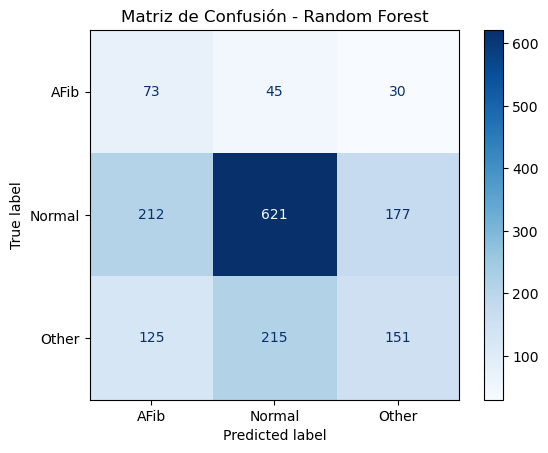

In [616]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(modelo, X_test_scaled, y_test, cmap='Blues')
plt.title("Matriz de Confusión - Random Forest")
plt.show()


## 9. Reporte completo

In [617]:
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))


Reporte de Clasificación:
              precision    recall  f1-score   support

        AFib       0.18      0.49      0.26       148
      Normal       0.70      0.61      0.66      1010
       Other       0.42      0.31      0.36       491

    accuracy                           0.51      1649
   macro avg       0.43      0.47      0.42      1649
weighted avg       0.57      0.51      0.53      1649



## Conclusiones de la Etapa 2

- Se procesaron archivos .mat de señales ECG, extrayendo características estadísticas del intervalo RR: mean_rr, std_rr, skew_rr y kurt_rr, junto con sus etiquetas (Normal, AFib, Other) desde REFERENCE.csv.

- Se utilizaron múltiples modelos clásicos de scikit-learn como Árboles de Decisión, Random Forest, Redes Neuronales (MLP) y SVM. De todos ellos, el modelo que logró el mejor desempeño general y, en especial, el mejor recall para la clase AFib, fue el SVM con kernel RBF, C=10 y class_weight='balanced'.

- Este modelo obtuvo un recall de 0.49 para AFib, que es clave en contextos clínicos donde es más grave no detectar un caso verdadero. El accuracy global fue de 0.51, con métricas balanceadas entre clases (macro avg f1-score ≈ 0.42).

- Si bien el modelo aún tiene espacio para mejorar, el objetivo prioritario de detectar fibrilación auricular se cumple de manera más efectiva con SVM, en comparación con otros enfoques clásicos.
